In [142]:
import numpy as np
import copy as cp
import csv
import time as tp
import pandas as pd
import gc
import matplotlib.pyplot as plt

# Introducci&oacute;n
El sudoku es un juego que tiene los siguientes componentes:

<ul>
    <li> Una cuadricula de 9x9 dividida en 9 regiones de 3x3 </li>
    <li> Al comienzo se cuentan con casillas con valores asignados</li>
    <li> Las casillas restantes deben ser llenadas con n&uacute;meros del 1 al 9 </li>
    <li> Se deben cumplir las siguientes restricciones:
        <ul>
            <li> Un n&uacute;mero no se puede repetir en la misma fila</li>
            <li> Un n&uacute;mero no se puede repetir en la mimsa columna</li>
            <li> Un n&uacute;mero no se puede repetir en la misma region</li>
        </ul>
    </li>
</ul>



## Sudoku como un CSP
El juego puede ser planteado como un CSP ya que en el mismo se pueden encontrar los diferentes componentes de un CSP los cuales son:
<ul>
    <li> Variables </li>
    <li> Dominios </li>
    <li> Restricciones </li>
    <li> Modelo </li>
</ul>

Si comenzamos a analizar el sudoku podemos identificar que estos componentes son los siguientes

<ul>
    <li>Variables: Estas pueden ser definidas como todas y cada una de las posiciones vacías del tablero. </li>
    <li>Dominios: Son todos y cada uno de los posibles valores que pueden ser asignados a cada una de las variables, para este caso un dominio para una variable va con números desde el 1 al 9.  </li>
    <li>Restricciones: Son las reglas que tenemos para completar el juego.
        <ul>
            <li>No se puede repetir un número en una misma fila.  </li>
            <li>No se puede repetir un número en una misma columna. </li>
            <li>No se puede repetir un número en la misma región.  </li>
        </ul>
    </li>
    <li>Modelo: Es una combinación de valores para cada variable que satisface todas y cada una de las restricciones, en este caso se puede ver como la soluci&oacute;n al tablero. </li>
    
</ul>











### Clase base para el tablero 

En esta clase se colocaron los siguientes m&eacute;todos:

<ul>
    <li>printBoard: Realiza una impresi&oacute;n del tablero</li>
    <li>getRange: Obtiene el rango de filas y columnas de un cuadrante o regi&oacute;n determinado</li>
    <li>getCuadrant: Obtiene el cuadrante de una posici&oacute;n dada</li>
    <li>getCuadrantMoves: Obtiene las posiciones del cuadrante</li>
    <li>getRowsandCols: Obtiene las filas y columnas que inciden para una posici&oacute;n dada</li>
    <li>checkRowsandCols: Checa que el tablero sea valido en filas y columnas de una posici&oacute;n dada</li>
    <li>checkCuadrant: Checa que el tablero sea valido en una region incidente de una posici&oacute;n dada</li>
    <li>isOk: Verifica que una posici&oacute;n sea valida</li>
    <li>isValid: Verifica que el tablero sea valido</li>
    <li>isGoal: Verifica si el tablero es el objetivo</li>
</ul>

In [122]:
class Sudoku:
    
    board = None
    size = None
    
    def __init__(self,file = None, board = None, size = None):
        
        if file:
            self.board = np.zeros((9,9))
            self.size = 9
            with open(file) as csv_file:
                csv_reader = csv.reader(csv_file,delimiter = ',')
                
                for i,row in enumerate(csv_reader):
                    for j,number in enumerate(row[1:]):
                        if number != '':
                            self.board[i,j] = number
        else:
            self.board = board
            self.size = size


    def printBoard(self):
        print "\n"
        for i in range(0,9):
            print self.board[i,0:3], "|",self.board[i,3:6],"|",self.board[i,6:9]
            if (i+1)%3 == 0 and i!= 8:
                print "------------------------------------"
        print "\n"
        
        
    def getRange(self,cuadrant):
        
        row,col = [],[]
        
        if cuadrant <3 :
            row = range(0,3)
            
        if cuadrant >= 3 and cuadrant< 6:
            row = range(3,6)
            
        if cuadrant >= 6 and cuadrant < 9:
            row = range(6,9)

        if cuadrant in (0,3,6):
            col = range(0,3)
        
        if cuadrant in (1,4,7):
            col = range(3,6)
                    
        if cuadrant in (2,5,8):
            col = range(6,9)
        
        return row,col
        
    def getCuadrant(self,pos):
        
        row,col =  pos
        
        if row <3:
            cuad = 0
        
        if row >=3 and row <6:
            cuad = 3
        
        if row >=6:
            cuad = 6
        
        cuad += col/3
        
        return cuad
    
    def getCuadrantMoves(self,nums):
        rows,cols = nums

        moves = []
        for i in rows:
            for j in cols:
                moves.append((i,j))
                
        return moves
        
    
    def checkCuadrant(self,pos):
        cuad = self.getCuadrant(pos)        
        rows,cols = self.getRange(cuad)
        
        if self.board[pos] == 0:
            return True
            
        
        for i in rows:
            for j in cols:
                if (i,j) != pos and self.board[i,j] == self.board[pos]:
                    return False
        
        return True
    
    def getRowsandCols(self,pos):
        row,col = pos
        moves = []
        for i in range(self.size):
            if i != row and not (i,col) in moves:
                moves.append((i,col))
            if i != col and not (row,i) in moves:
                moves.append((row,i))
        
        return moves
        
    def checkRowandCol(self,pos):
        row,col = pos
        
        if self.board[pos]==0:
            return True
        
        moves = self.getRowsandCols(pos)
        
        for mov in moves:
            if self.board[mov] == self.board[row,col]:
                return False            
        return True    
    
    #Funcion que verifica que la posicion no tenga conflictos
    def isOk(self,pos):
        
        if not self.checkCuadrant(pos) or not self.checkRowandCol(pos):
            return False
        return True
    
    def isValid(self):

        for i in range(self.size):
            for j in range(self.size):
                if not self.isOk((i,j)):
                    return False
        return True
    
    #Funcion que verifica que el tablero este resuelto
    def isGoal(self): 
     
        for i in range(self.size):
            for j in range(self.size):
                if not self.isOk((i,j)) or self.board[i,j] == 0:
                    return False
        return True

## BackTracking
El BackTracking prueba todas y cada una de las posibilidades en el tablero.

### Clase para el BackTracking

En esta clase se incluyen los metodos basicos para manejar el Backtracking:
<ul>
    <li>getNeighbours: Obtiene los tableros modificados con el dominio de la variable que esta siendo analizada actualmente</li>
    <li>getEmpty: Obtiene las posiciones vacias del tablero</li>
    <li>createNeighbour: Crea el tablero vecino con el valor, y la posici&oacute;n a modificar</li>
</ul>

In [123]:
class Back(Sudoku):
    board = None
    neighbours = None
    domains = None
    variables = None
    
    def __init__(self,file = None, board = None, size = None):
        
        Sudoku.__init__(self,file,board,size)
        self.domains = {}
        constraints = {}
        
        self.variables = self.getEmpty()
        
        for i in self.variables:
                    
            moves = self.getRowsandCols(i)
            cuad = self.getCuadrant(i)
                    

            moves += self.getCuadrantMoves((self.getRange(cuad)))
                    
            value = self.board[i]
            constraints[i] = moves

                
        for var in self.variables:
            if self.board[var] == 0:

                posdomain = range(1,self.size+1)
                self.domains[var] = []
                for num in posdomain:
                    
                    find = False
                    
                    for i in constraints[var]:
                        if self.board[i] == num:
                            find = True
    
                    if not find:                    
                        self.domains[var].append(num)

        if len(self.variables) > 0:
            self.getNeighbours(self.variables[0])
        else:
            self.neighbours  = []

    
        
    
    def getEmpty(self):
        empty = []
        for i in range(self.size):
            for j in range(self.size):
                if self.board[i,j] == 0:
                    empty.append((i,j))
        return empty
    
    def createNeighbour(self,pos,value):
        
        board = self.board.copy()
        board[pos] = value
        return (board,self.size)
    
    
        
    
    def getNeighbours(self,actual):
        self.neighbours = []
        values = range(1,10)
        
        for i in self.domains[actual]:
            self.neighbours.append(self.createNeighbour(actual,i))


### execBack()
Ejecuci&oacute;n  basica de un BackTracking

<ul>
    <li> Verificar si el nodo es el objetivo en caso de serlo regresar el nodo</li>
    <li> Verificar si el nodo es valido, en caso de no regresar False</li>
    <li> Para cada vecino del nodo:
        <ul>
            <li>Creamos un nodo nuevo</li>
            <li>Llamamos recursivamente a la funcion mandando el nuevo nodo como parametro</li>
            <li>Si la llamada recursiva regresa algo diferente a False, regresamos esa respuesta</li>
        </ul>
    </li>
    <li>Regresamos Falso</li>
</ul>


In [124]:
def execBack(node):
    
    if node.isGoal():
        return node
    
    if not node.isValid():
        return False


    
    for vec in node.neighbours:
    
        ans =  execBack(Back(None,vec[0],vec[1]))
        if ans:
            return ans
    
    return False

## AC3

Este algoritmo ayuda a reducir el dominio de las variables para reducir el tiempo de la búsqueda por profundidad.

El algoritmo prueba cada valor del dominio de una variable contra el arco de otra variable para verificar que sea consistente con su arco y el de la otra variable

Es necesario mencionar que solamente se toma en cuenta la parte del arco de la seugnda variable que tiene en comun con la primera valriable, en caso de no ser consistente con los arcos se elimina de la variable.

En casos muy especificos este algoritmo puede resolver el tablero, esto sucede cuando el dominio de todas las variables es reducido a un solo valor.


### Clase para el AC3

Al crear el nodo se inicializan las variables si es que no ha sido resuelto con anterioridad

#### Inicializaci&oacute;n:
<ul>
    <li>Creamos una lista de variables</li>
    <li>Creamos los dominios base de todas las variables</li>
    <li>Obtenemos una lista de restricciones unitarias para cada variable</li>
    <li>Creamos una lista de restricciones binarias</li>
</ul>

#### Metodos de la clase:

<ul>
    <li>getArea: Obtiene todas las posiciones que inciden en una variable</li>
    <li>esConsistente: Verifica que el valor analizado sea consistente respecto al arco de su variable de origen y el arco de la segunda variable</li>
    <li>arcReduce: Checa todos los valores del dominio de una variable con respecto al arco de otra variable, en caso de no ser consistente lo elimina del dominio</li>
    <li>getNeighbours: Obtiene los vecinos del tablero actual</li>
</ul>

In [125]:
class Ac3(Sudoku):
    domains = None
    constraints = None
    variables = None
    asig = None
    nextV = None
    
    def __init__(self,file = None, board = None, size = None,solved = False,domains = None,variables = None):
        
        Sudoku.__init__(self,file,board,size)
        
        if solved:
            self.variables = variables
            self.domains = domains
            return
        
        self.variables = []
        self.domains = {}
        self.constraints = [] # Posiciones que se afectan entre si
        self.places = {} #Direct con las posiciones que afectan a una variable en especifico
        self.asig = {}  #Valores ya asignados
        
        #Creamos un arreglo con las variables
        for i in range(self.size):
            for j in range(self.size):
                self.variables.append((i,j))
                
        
        for i in self.variables:
            if self.board[i] != 0:
                self.asig[i] = [self.board[i]]
                self.domains[i] = [self.board[i]]
                
            else:
                self.domains[i] = range(1,10)
                self.asig[i] = 0
        
        #Llenamos el direct de posiciones que afectan a una variable
        for i in self.variables:
            self.places[i] = []
            
            moves = sorted(self.getArea(i), key = lambda ax: ax[0])
            index = moves.index(i)
            moves.pop(index)
            
            self.places[i] = moves
            
        for i in self.variables:
            for j in self.places[i]:
                self.constraints.append((i,j))
                
		


    def getArea(self,pos):
        moves = self.getRowsandCols(pos)
        cuad = self.getCuadrant(pos)
        for i in self.getCuadrantMoves((self.getRange(cuad))):
            if not i in moves:
                moves.append(i)
        
        return moves
    
    def esConsistente(self,x,var1,var2):
        
        for y in self.domains[var2]:
            if var2 in self.places[var1] and y!= x:
                return True
        return False
    
    def arcReduce(self,var1,var2):
        
        flag = False
        
        for i in self.domains[var1]:
            if not self.esConsistente(i,var1,var2):

                index = self.domains[var1].index(i)
                self.domains[var1].pop(index)

                flag = True
        return flag
    
    def getNeighbours(self,var):
        
        vecs = []
        vari = self.variables[var]
        
        for i in self.domains[vari]:
            board = self.board.copy()
            board[vari] = i
            #
            vecs.append(board)
        
        band = True
        while band:
            var += 1
            
            if var < len(self.variables):
                vari = self.variables[var]

            
                if self.board[vari] == 0:
                    band = False
            else:
                
                band = False
                
        self.nextV = var
        return vecs
    
       

### Funci&oacute;n que ejecuta el AC3

<ul>
    <li> Generamos una cola con las restricciones binarias </li>
    <li> Mientras la cola no este vacia
        <ul>
            <li>Sacamos el proximo elemento de la cola</li>
            <li>Verificamos el dominio de la primera variable con los arcos de su variable y la segunda</li>
            <li>Si ocurrio una reduccion y el dominio de la primera variable no esta vacio se agrega a la cola nuevos elementos que son correspondientes a su arco, en caso de que el dominio este vacio regresamos Falso y termina el algoritmo</li>
        </ul>
    </li>
    <li>Regresamos Verdadero</li>
</ul>




In [126]:
def execAC3(node):
    
    cola = []
    
    for evaluate in node.constraints:
        cola.append(evaluate)
    
    while cola:
        
        var1,var2 = cola.pop(0)
        
        if node.arcReduce(var1,var2):
            if len(node.domains[var1]) == 0:
                return False
            
            for news in node.places[var1]:

                if news != var1:

                    cola.append((news,var1))

    return True


### Funcion que ejecuta Backtracking con AC3

In [127]:
def execBackAc3(node,actual):
    
    if not node.isValid() or len(node.variables) < actual:
        return False    
    
    if node.isGoal():
        
        node.printBoard()
        return True
    

    
    for i in node.getNeighbours(actual):

        new_node = Ac3(None,i,node.size,domains=node.domains,variables=node.variables,solved=True)
        if execBackAc3(new_node,node.nextV):
            return True
    
    return False


### Funcion que ejecuta ambos algoritmos

In [128]:
def execAll(file):
    
    back = Back(file) 
    print ("\n---------------- Tablero a resolver ----------------")
    back.printBoard()
    
    print("\n---------------- BackTracking ---------------------")
    prev = tp.time()
    res = execBack(back)
    res.printBoard()
    backt = tp.time() - prev
    print"------ Resuelto en: ",backt,"segundos ------"
    
    
    
    print("\n---------------- AC3 ---------------------")
    ac = Ac3(file)
    prev = tp.time()
    execAC3(ac)
    execBackAc3(ac,0)
    act = tp.time() - prev
    print"------ Resuelto en: ",act,"segundos ------"    
    
    return backt,act


### Funcion que realiza pruebas 

In [129]:
def test(dif,cant):
    
    backtime,actime = [],[]
    
    for i in range(cant):
        
        print "\n****************** NUEVA PRUEBA ******************\n"
        
        if i == 0:
            file = dif + ".csv"
        else:
            file = dif+str(i+1)+".csv"
            
        bt,ac = execAll(file)

        
        backtime.append(bt)
        actime.append(ac)
        gc.collect()
        

        
    return backtime,actime

# Pruebas
## Dificultad: Facil

In [130]:
easyb,easyac=test("easy",10)


****************** NUEVA PRUEBA ******************


---------------- Tablero a resolver ----------------


[0. 4. 0.] | [2. 5. 0.] | [0. 0. 9.]
[2. 9. 0.] | [0. 0. 8.] | [0. 3. 0.]
[0. 0. 0.] | [0. 0. 0.] | [0. 0. 0.]
------------------------------------
[0. 0. 0.] | [0. 7. 0.] | [1. 9. 0.]
[3. 7. 0.] | [9. 0. 5.] | [0. 0. 2.]
[6. 0. 0.] | [0. 0. 4.] | [0. 0. 0.]
------------------------------------
[0. 5. 4.] | [1. 0. 0.] | [6. 2. 0.]
[0. 0. 0.] | [0. 0. 0.] | [0. 0. 0.]
[0. 6. 0.] | [0. 0. 0.] | [5. 0. 0.]



---------------- BackTracking ---------------------


[7. 4. 6.] | [2. 5. 3.] | [8. 1. 9.]
[2. 9. 1.] | [6. 4. 8.] | [7. 3. 5.]
[5. 8. 3.] | [7. 9. 1.] | [2. 4. 6.]
------------------------------------
[4. 2. 5.] | [3. 7. 6.] | [1. 9. 8.]
[3. 7. 8.] | [9. 1. 5.] | [4. 6. 2.]
[6. 1. 9.] | [8. 2. 4.] | [3. 5. 7.]
------------------------------------
[9. 5. 4.] | [1. 8. 7.] | [6. 2. 3.]
[1. 3. 7.] | [5. 6. 2.] | [9. 8. 4.]
[8. 6. 2.] | [4. 3. 9.] | [5. 7. 1.]


------ Resuelto en

## Dificultad: Media

In [131]:
medb,medac=test("Medium",10)


****************** NUEVA PRUEBA ******************


---------------- Tablero a resolver ----------------


[2. 5. 0.] | [0. 9. 0.] | [0. 0. 3.]
[6. 0. 0.] | [0. 0. 0.] | [0. 0. 0.]
[0. 0. 8.] | [0. 5. 4.] | [0. 0. 0.]
------------------------------------
[0. 0. 9.] | [0. 8. 7.] | [0. 0. 0.]
[0. 0. 0.] | [0. 0. 0.] | [1. 0. 6.]
[0. 0. 4.] | [0. 2. 0.] | [5. 0. 0.]
------------------------------------
[0. 0. 0.] | [0. 0. 0.] | [0. 9. 4.]
[0. 8. 0.] | [0. 0. 0.] | [0. 0. 0.]
[0. 1. 7.] | [0. 0. 2.] | [0. 0. 0.]



---------------- BackTracking ---------------------


[2. 5. 1.] | [6. 9. 8.] | [7. 4. 3.]
[6. 4. 3.] | [2. 7. 1.] | [9. 5. 8.]
[7. 9. 8.] | [3. 5. 4.] | [6. 2. 1.]
------------------------------------
[1. 6. 9.] | [5. 8. 7.] | [4. 3. 2.]
[5. 7. 2.] | [4. 3. 9.] | [1. 8. 6.]
[8. 3. 4.] | [1. 2. 6.] | [5. 7. 9.]
------------------------------------
[3. 2. 6.] | [7. 1. 5.] | [8. 9. 4.]
[4. 8. 5.] | [9. 6. 3.] | [2. 1. 7.]
[9. 1. 7.] | [8. 4. 2.] | [3. 6. 5.]


------ Resuelto en

## Dificultad: Dificil

In [133]:
hdb,hdac=test("Hard",5)


****************** NUEVA PRUEBA ******************


---------------- Tablero a resolver ----------------


[0. 0. 2.] | [0. 1. 5.] | [3. 0. 0.]
[5. 0. 0.] | [9. 0. 6.] | [7. 0. 0.]
[0. 1. 0.] | [0. 0. 0.] | [6. 0. 0.]
------------------------------------
[0. 0. 0.] | [0. 5. 0.] | [4. 7. 1.]
[0. 0. 1.] | [7. 0. 0.] | [0. 0. 0.]
[0. 0. 0.] | [0. 0. 2.] | [0. 5. 0.]
------------------------------------
[0. 9. 0.] | [0. 2. 0.] | [0. 4. 0.]
[0. 0. 0.] | [0. 0. 0.] | [0. 0. 3.]
[4. 0. 0.] | [3. 0. 1.] | [0. 0. 0.]



---------------- BackTracking ---------------------


[7. 6. 2.] | [8. 1. 5.] | [3. 9. 4.]
[5. 8. 3.] | [9. 4. 6.] | [7. 1. 2.]
[9. 1. 4.] | [2. 7. 3.] | [6. 8. 5.]
------------------------------------
[2. 3. 9.] | [6. 5. 8.] | [4. 7. 1.]
[8. 5. 1.] | [7. 9. 4.] | [2. 3. 6.]
[6. 4. 7.] | [1. 3. 2.] | [8. 5. 9.]
------------------------------------
[3. 9. 6.] | [5. 2. 7.] | [1. 4. 8.]
[1. 7. 8.] | [4. 6. 9.] | [5. 2. 3.]
[4. 2. 5.] | [3. 8. 1.] | [9. 6. 7.]


------ Resuelto en

## Funcion que procesa los datos 

In [140]:
def processData(ebt,eac,mbt,mac,hbt,hac):
    
    bmeans,ameans,bsds,asds = [],[],[],[]
    
    bmeans.append(np.mean(ebt))
    bmeans.append(np.mean(mbt))
    bmeans.append(np.mean(hbt))
    
    ameans.append(np.mean(eac))
    ameans.append(np.mean(mac))
    ameans.append(np.mean(hac))
    
    
    bsds.append(np.std(ebt))
    bsds.append(np.std(mbt))
    bsds.append(np.std(hbt))
    
    
    asds.append(np.std(eac))
    asds.append(np.std(mac))
    asds.append(np.std(hac))
    
    
    return [bmeans,ameans,bsds,asds]


data = processData(easyb,easyac,medb,medac,hdb,hdac)
data

[[130.84657082557678, 199.65073068141936, 496.8078192710876],
 [72.76537089347839, 64.1702879190445, 278.0351393699646],
 [273.4521908692172, 213.7615205687355, 388.1025583855219],
 [179.43335026464294, 71.60230282099668, 163.2835838800191]]

## Tabla comparativa de tiempos

In [158]:
indexes = ["Easy","Medium","Hard"]
dataset = pd.DataFrame({"BackTracking Mean":data[0],"AC3 Mean": data[1],"AC Sd":data[3],"BT Sd": data[2]},index = indexes)
dataset    

,AC Sd,AC3 Mean,BT Sd,BackTracking Mean
Easy,179.433350,72.765371,273.452191,130.846571
Medium,71.602303,64.170288,213.761521,199.650731
Hard,163.283584,278.035139,388.102558,496.807819


## Grafica donde se puede ver la distribucion de tiempos

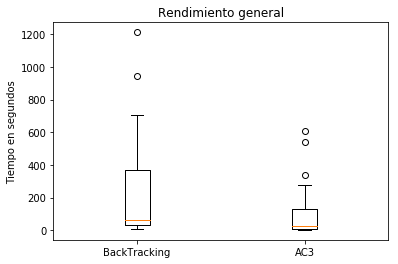

In [178]:
fig, ax = plt.subplots(1,1)
ax.set_title("Rendimiento general")
ax.set_ylabel("Tiempo en segundos")
ax.boxplot((np.concatenate([easyb,medb,hdb]),np.concatenate([easyac,medac,hdac])))
ax.set_xticklabels(("BackTracking", "AC3"), fontsize=10)
plt.show()

# Conclusiones

Despues de las pruebas realizadas, se puede ver que el algoritmo AC3 reduce drasticamente el tiempo que tarda en ejecutarse la busqueda en profundidad, sin embargo es importante recalcar que las distribuciones de tiempo fueron muy cercanas en las dificultades mas bajas ya que la respuesta al tablero es muy rapida de encontrar.

Por otro lado en las dificultades mas altas BackTracking debe probar practicamente todos y cada uno de los posibles valores de cada variable en el tablero lo que nos lleva a una busqueda de aproximadamente 
D^n

$D^{n}$

Donde D es la cantidad de valores en el dominio y n es la cantidad de variables en el tablero.

Aqui es donde se nota la mejoria con AC3 ya que reduce el dominio intentando podar los nodos "muertos" sin siquiera entrar a la busqueda en profundidad haciendo la busqueda mucho mas rapida al tener una menor cantidad de posibilidades que probar.